In [1]:
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import json

%matplotlib inline

# Wrapper

Steps for using the wrapper:

* Load coordinates using Biopython
* Center and rotate the coordinates
* Save them as rcoord.txt, where r is x, y or z
* Create parameters file 
* Run the c++ code
* Load the projected image and the json with the cv and its gradient
* Enjoy

In [2]:
#First let's create some functions

def center_atomic_coord (x,y,z):
    
    x, y, z = x-np.mean(x), y-np.mean(y), z-np.mean(z)
    return(x, y, z) 

def quaternion_rotation(q, x, y, z):
    
    '''
    Performs a rotation using quaternions.
    
    If it is based from a quaternion q1 = w + xi + yj + zk, then the 
    quaternion array q should be q = [x, y, z, w]
    '''
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)

    

def read_grads():
    # Retrieve gradients of each training step fron the text output files
    # from the c++ program

    with open("../data/output/grad.json") as j_file:
        data = json.load(j_file)[0]
        s = data["s"]
        x_grad = np.array(data['sgrad_x']) 
        y_grad = np.array(data['sgrad_y'])
        z_grad = np.array(data['sgrad_z'])

        return s, np.array([x_grad, y_grad, z_grad])

In [3]:
%%capture
#Load data using Biopython

#Importat 1xck's PDB to extract XYZ atomic coordinates
parser = PDB.PDBParser()
io = PDB.PDBIO()
struct = parser.get_structure('1xck','../data/input/1xck.pdb')

x_atom=[]
y_atom=[]
z_atom=[]

for chains in struct:
    for chain in chains:
        for residue in chain:                             
            for atom in residue:
                x_atom.append(atom.get_vector()[0])
                y_atom.append(atom.get_vector()[1])
                z_atom.append(atom.get_vector()[2])
                
                
x_atom=np.array(x_atom)
y_atom=np.array(y_atom)
z_atom=np.array(z_atom)

In [5]:
#Quaternion parameters
'''
If it is based from a quaternion q1 = w + xi + yj + zk, then the 
quaternion array q should be q = [x, y, z, w]
'''

q=[0, 1/np.sqrt(2), 1/np.sqrt(2), 0]

#Center the coordinates
x_atom, y_atom, z_atom = center_atomic_coord (x_atom, y_atom, z_atom)

#Rotate them
x_atom, y_atom, z_atom = quaternion_rotation(q, x_atom, y_atom, z_atom)

#Save the coordinates
np.savetxt("../data/input/xcoord.txt", x_atom)
np.savetxt("../data/input/ycoord.txt", y_atom)
np.savetxt("../data/input/zcoord.txt", z_atom)

In [6]:
#Create the parameters file

n = 3; sigma = 1; res = 128

fout = open("../data/input/parameters.txt","w")
fout.write("""N = {n}
S = {s}
R = {r}
""".format(n=n, s=sigma, r=res))
fout.close()

In [7]:
#run the c++ code

#uncomment if it is not compiled yet
#Arley since you're using windows I think you're going to have a few problems
#I'll try to make a makefile for you, but I have no way to test it

#os.system("cd .. && make");

os.system("cd .. && ./main.out");

In [8]:
#Load the projected image
Ixy = np.loadtxt("../data/output/Ical.txt")

#Load the json with the cv and its gradient
s, sgrad = read_grads()

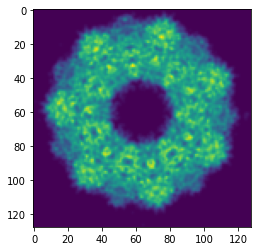

In [9]:
#Checking that everything worked

plt.imshow(Ixy)